# 20 Newsgroups

In [1]:
from src.model_utils import *
from src.estimator import *
import numpy as np

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

from sklearn.pipeline import Pipeline

from gensim.models import Word2Vec

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import eli5
from eli5.lime import TextExplainer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## EDA

### Data loading

Let's get the raw texts and strip newsgroup-related metadata such as headers, signature blocks and quotation blocks for more realistic results. <br>
More info about how headers, footers and quotes may affect predictions you may find [here](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html#filtering-text-for-more-realistic-training)  - on sklearn documentation about 20 newsgroups dataset.

In [2]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

newsgroups_train.data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

### Data quality checks

Let's see what are unique categories of our text data.

In [3]:
target_names = newsgroups_train.target_names

categories = list(target_names)
print(f'We have {len(categories)} different topics:\n')

for i, cat in enumerate(categories):
    print(f'{i}. {cat}')

We have 20 different topics:

0. alt.atheism
1. comp.graphics
2. comp.os.ms-windows.misc
3. comp.sys.ibm.pc.hardware
4. comp.sys.mac.hardware
5. comp.windows.x
6. misc.forsale
7. rec.autos
8. rec.motorcycles
9. rec.sport.baseball
10. rec.sport.hockey
11. sci.crypt
12. sci.electronics
13. sci.med
14. sci.space
15. soc.religion.christian
16. talk.politics.guns
17. talk.politics.mideast
18. talk.politics.misc
19. talk.religion.misc


Some of the newsgroups are very closely related to each other (like ***comp.sys.ibm.pc.hardware*** / ***comp.sys.mac.hardware***, ***rec.sport.baseball*** / ***rec.sport.hockey***), while others are highly unrelated.

In [4]:
print(f'Filenames shape is {newsgroups_train.filenames.shape}\nTarget shape is {newsgroups_train.target.shape} ')

Filenames shape is (11314,)
Target shape is (11314,) 


### Insights about target

Let's see what our target looks like and whether we have the balanced data.

In [5]:
newsgroups_train.target[:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

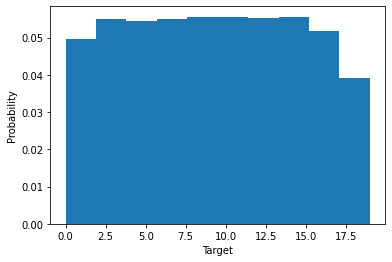

In [6]:
plt.hist(newsgroups_train.target, density=True)
plt.xlabel('Target')
plt.ylabel('Probability')
plt.show()

From the histogram above we conclude that we deal with balanced data so one of our evaluation metrics would be accuracy.

## Text preprocessing. Modeling

So far we have raw text data and we need to extract features for our future models - we'll use **vectorization** (turn a collection of text documents into numerical feature vectors). <br> 
We'll start with the basic text preprocessing approach - **bag of words**. We'll use **tf-idf** as preprocessing step and **multinomual naive bayes model** as an estimator. 

### TF-IDF & MultinomialNB

- **Bag of Words** 

This strategy includes tokenization, counting and normalization. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

- **Tf-idf**  

It's commonly used in order to re-weight the count features into floating point values. <br>
**Tf** means term-frequency while **tf–idf** means term-frequency times inverse document-frequency: `tf-idf(t, d) = tf(t, d) x idf(t)` <p>
The term frequency, the number of times a term occurs in a given document, is multiplied with idf component, which is computed as:

$$idf(t)=\log(\frac{1+n}{1+df(t)}) + 1$$

where $n$ is the total number of documents in the document set, and $df(t)$ is the number of documents in the document set that contain term $t$. <br>
The resulting tf-idf vectors are then normalized by the Euclidean norm.
    
- **Multinomail NB**

It's one of the classic naive Bayes variants used in text classification. <br>
The distribution is parametrized by vectors $\theta_y = (\theta_{y_1}, \dotsc, \theta_{y_n})$ for each class $y$ where $n$ is the number of features (the size of the vocabulary) and $\theta_{y_i}$ is the probability $P(x_i|y)$ of feature $i$ appearing in a sample belonging to class $y$.

    

In [7]:
X_train, y_train = newsgroups_train.data, newsgroups_train.target
X_test, y_test = newsgroups_test.data, newsgroups_test.target

In [8]:
pipe = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [9]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

f1 score = 0.5854345727938506
accuracy = 0.6062134891131173


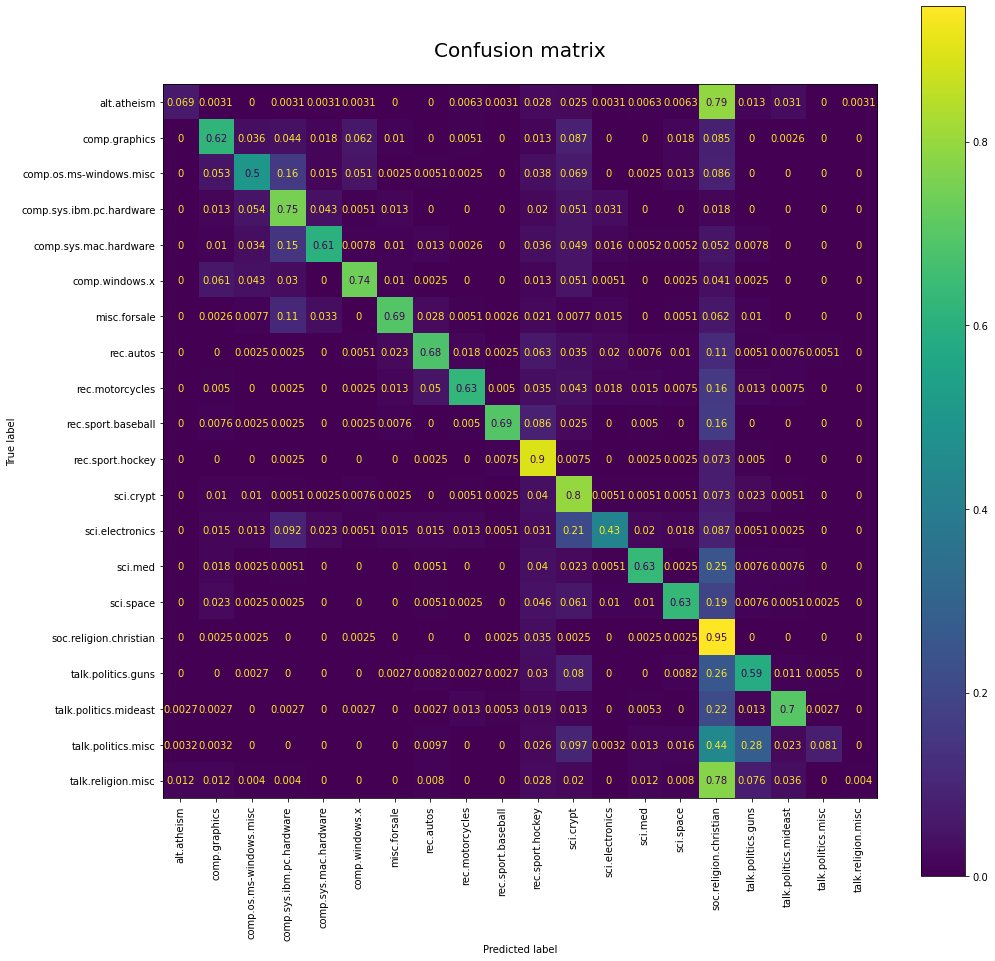

In [10]:
f1, acc = evaluate(y_test, y_pred, labels=categories)
print(f'f1 score = {f1}\naccuracy = {acc}')

So from the confusion matrix above the first and two last cells on the main diagonal are hardly seen which means that our multinomial naive bayes model isn't able to classify these categories correctly. Also our model almost every text classifies as 15's topic which is **soc.religion.christian**, especially the first and the last topics are misclassified with **soc.religion.christian** theme. <br> Let's try another model - linear svc and look into the errors.

## Model Explanation

Firstly, we'll look into the most confident model's predictions. As we see at the confusion matrix above the model classifies best such topics: **soc.religion.christian** and **rec.sport.hockey**.

In [11]:
doc = find_doc_on_theme('soc.religion.christian', target_names, y_test, X_test)
show_text_explanation(doc, pipe.predict_proba, target_names)


Metrics:{'mean_KL_divergence': 0.019073291898391884, 'score': 0.757574842588758}



In [ ]:
# miclassified_theme_indexes = np.nonzero(cm[15])[0]
# miclassified_theme_names = list(np.array(target_names)[miclassified_theme_indexes])
# miclassified_theme_names

The probability that text is classified as **soc.religion.christian** theme is only **12.8%** which isn't so high as we expected. Also we see that the probability that text may be classified as **rec.sport.hockey** theme is **10.7%** which is strange, because for us - humans it's obvious that this text isn't about any sport. However we see that such words - **money**, **dwindles**, **grow** (that contributed more in model's prediction) may correspond to the sport themes.

Metrics allow us to check the trustworthiness of explanations.

- **KL-Divergence** tells us how similar 2 probability distributions are — and we want this number to be as small as possible (i.e. the probability distributions are pretty much the same).
- **The score** metric metric is our local model accuracy (the higher the better).

Let's now do the same explanation of the text corresponding to rec.sport.hockey topic.

In [12]:
doc = find_doc_on_theme('rec.sport.hockey', target_names, y_test, X_test)
show_text_explanation(doc, pipe.predict_proba, target_names)


Metrics:{'mean_KL_divergence': 0.05683938206263761, 'score': 0.9143809117512159}



The probability that text is classified as rec.sport.hockey theme is 29.9%. Also metrics are higher this time.

Now let's explore some texts that your model failed to classify correctly. Let's begin with **talk.religion.misc**.

In [13]:
doc = find_doc_on_theme('talk.religion.misc', target_names, y_test, X_test)
show_text_explanation(doc, pipe.predict_proba, target_names)


Metrics:{'mean_KL_divergence': 0.021114191779278785, 'score': 0.8354622200447736}



So we see that probablity that text belongs to **alt.atheism** or **soc.religion.christian** themes is higher than the probability that text corresponds to actual topic (the same behaviour we observe looking at confusion matrix). As for me it's hard to relate this sentence to specific topic - some of the topics intersect. 

### TF-IDF & LinearSVC

- **Linear SVC**

Similar to SVC with parameter kernel=`linear`, but it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

In [14]:
pipe_lsvc = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('lsvc', LinearSVC())
])

In [15]:
pipe_lsvc.fit(X_train, y_train)
y_pred_lsvc = pipe_lsvc.predict(X_test)

f1 score = 0.6810391634643981
accuracy = 0.6919808815719597


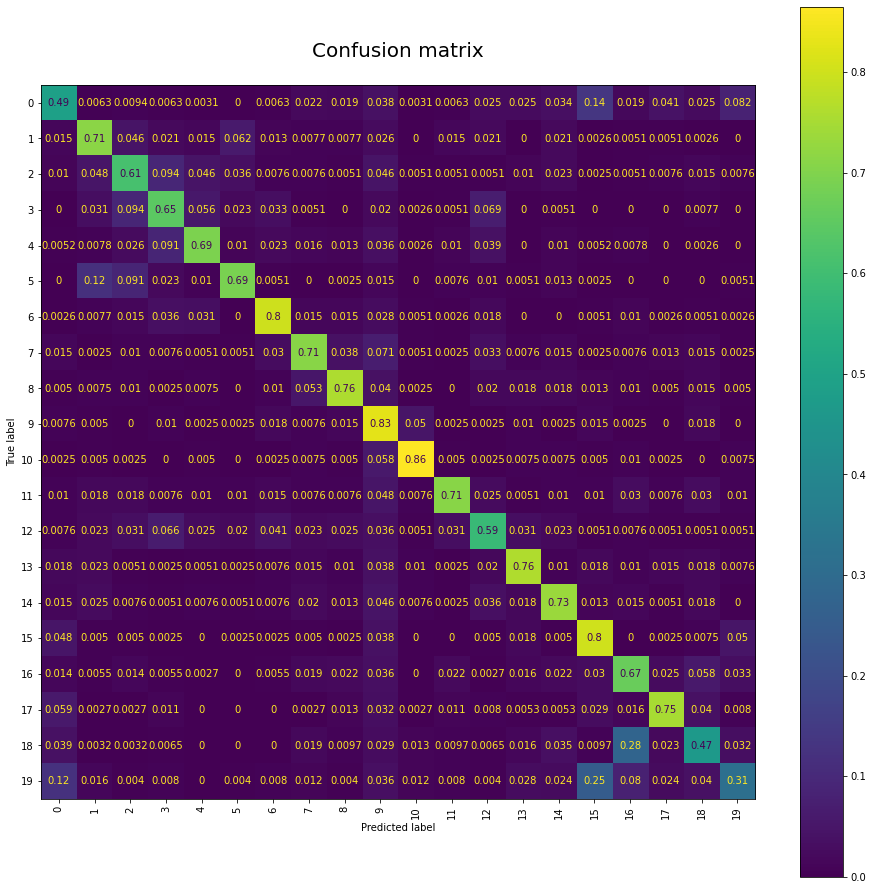

In [16]:
f1, acc = evaluate(y_test, y_pred_lsvc)
print(f'f1 score = {f1}\naccuracy = {acc}')

Now we see more clear all the main diagonal. There're still some misclassifications that model made (**19's - with 15's**, **18's - with 16's**), but **soc.religion.christian** topic now isn't assigned to most texts as we saw before.

### Stemming vs Lemmatization

<br>**The point of using text normalization techniques:**

We have about 11.000 documents of 20 different topics that contain huge numbers of different words. Stemming or lemmatization allow to reduce words to their stem or lemma and decrease sparsity so it'll be easier to find patterns and make predictions for a model.

- **Stemming**

Words are reduced to their word stems. A word stem need not be the same root as a dictionary-based morphological root, it just is an equal to or smaller form of the word.
However, because stemming is usually based on heuristics, there're some bottlenecks in it - over- and understemming.

- **Lemmatization**

Resolves words to their dictionary form and to do so it needs to know its part of speech. That requires extra computational linguistics power such as a part of speech tagger.

---
**Why stemming?**

Using a huge dataset lemmatization is computationally expensive. Moreover our models use a tf-idf vectorizer and don't consider the context of the words of texts, so stemming is the best approach that we'll use.

- **Stemming**

In [24]:
tf_idf_custom = CustomVectorizer()
tf_idf_custom.fit_transform(X_train[:1])

<1x62 sparse matrix of type '<class 'numpy.float64'>'
	with 62 stored elements in Compressed Sparse Row format>

In [25]:
tf_idf_custom.get_feature_names_out()

array(['60s', '70s', 'addition', 'all', 'anyone', 'be', 'body',
       'bricklin', 'bumper', 'call', 'can', 'car', 'could', 'day', 'door',
       'early', 'engine', 'enlighten', 'from', 'front', 'funky', 'have',
       'history', 'if', 'in', 'info', 'is', 'it', 'know', 'late', 'look',
       'made', 'mail', 'me', 'model', 'name', 'of', 'on', 'or', 'other',
       'out', 'please', 'production', 'really', 'rest', 'saw', 'separate',
       'small', 'spec', 'sport', 'tellme', 'the', 'there', 'thi', 'to',
       'was', 'were', 'whatever', 'where', 'wonder', 'year', 'you'],
      dtype=object)

### Optimization with Optuna

In [ ]:
pipe = Pipeline([
    ('tf-idf', CustomVectorizer()),
    ('mnb', MultinomialNB())
])

pipe_lsvc = Pipeline([
    ('tf-idf', CustomVectorizer()),
    ('lsvc', LinearSVC())
])

In [ ]:
def objective(trial):
    
    classifier_name = trial.suggest_categorical('classifier', ['mnb', 'lsvc'])
    
    
    if classifier_name == 'mnb':
    
        param = {
        'tf-idf__max_df': trial.suggest_float('tf-idf__max_df', 0.1, 1.0),
        'tf-idf__min_df': trial.suggest_float('tf-idf__min_df', 0.1, 1.0),
        'tf-idf__ngram_range': trial.suggest_categorical('tf-idf__ngram_range', [(1, 1), (1, 2), (2, 2)]),
        'mnb__alpha': trial.suggest_float('mnb__alpha', 1e-8, 1.0, log=True)
        }
        
        model = pipe.set_params(**param)
    
    else: 
        param = {
            'tf-idf__max_df': trial.suggest_float('tf-idf__max_df', 0.1, 1.0),
            'tf-idf__ngram_range': trial.suggest_categorical('tf-idf__ngram_range', [(1, 1), (1, 2), (2, 2)]),
            'lsvc__C': trial.suggest_float('lsvc__C', 0.1, 10.0)
            
        }
        
        model = pipe_lsvc.set_params(**param)
    
   
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1, acc = evaluate(y_test, y_pred, print_cm=False)
    
    return acc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
pipe_params = trial.params

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in pipe_params.items():
    print('    {}: {}'.format(key, value))

In [ ]:
# pipe_params.pop('classifier')
pipe_lsvc.set_params(**pipe_params)

pipe_lsvc.fit(X_train, y_train)
y_pred = pipe_lsvc.predict(X_test)

In [ ]:
f1, acc = evaluate(y_test, y_pred)
print(f'f1 score = {f1}\naccuracy = {acc}')

In [ ]:
# old

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
pipe_params = trial.params

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in pipe_params.items():
    print('    {}: {}'.format(key, value))

In [ ]:
# old

# pipe_params.pop('classifier')
pipe_lsvc.set_params(**pipe_params)

pipe_lsvc.fit(X_train, y_train)
y_pred = pipe_lsvc.predict(X_test)

In [ ]:
# old

f1, acc = evaluate(y_test, y_pred)
print(f'f1 score = {f1}\naccuracy = {acc}')

Accuracy metrics are improved a little bit, but if we look on the main diagonal of confusion matrix, we may observe that:

- High coefficients get even higher after optimization, look at **10's, 15's, 6's, 17's** labels (and compare with the corresponding coefficients of the confusion matrix above).
- Low coefficients get even lower after optimization, check the **0's, 18's, 19's** labels.

So according to these insights it's hardly say that our model is actually more sucessfull in predictions than previous one, as we still failed in the classification of the less obvious texts.

### Voting Classifier

In [ ]:
pipe_rf = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [ ]:
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

In [ ]:
f1, acc = evaluate(y_test, y_pred_rf)
print(f'f1 score = {f1}\naccuracy = {acc}')

In [ ]:
nb = MultinomialNB()
svc = LinearSVC()
logr = LogisticRegression()

voting_clf = VotingClassifier(
estimators=[('mnb', nb), ('lsvc', svc), ('logr', logr)])

pipe_vote = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('voting_clf', voting_clf)
])

In [ ]:
pipe_vote.fit(X_train, y_train)
y_pred_vote = pipe_vote.predict(X_test)

In [ ]:
f1, acc = evaluate(y_test, y_pred_vote)
print(f'f1 score = {f1}\naccuracy = {acc}')

In [ ]:
def objective(trial):
    
    param = {
        'tf-idf__max_df': trial.suggest_float('tf-idf__max_df', 0.1, 1.0),
        'voting_clf__mnb__alpha': trial.suggest_float('mnb__alpha', 1e-8, 1.0, log=True),
        'voting_clf__lsvc__C': trial.suggest_float('lsvc__C', 0.1, 10.0),
        'voting_clf__logr__C': trial.suggest_float('logr__C', 0.1, 1.0)
        # 'voting_clf__rf__n_estimators': trial.suggest_int('rf__n_estimators', 50, 150),
        # 'voting_clf__rf__max_depth': trial.suggest_int('rf__max_depth', 2, 8),
        # 'voting_clf__rf__min_samples_split': trial.suggest_int('rf__min_samples_split', 2, 8)
    }
        
    model = pipe_vote.set_params(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1, acc = evaluate(y_test, y_pred, print_cm=False)
    
    return acc

In [ ]:
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
pipe_vote_params = trial.params

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in pipe_vote_params.items():
    print('    {}: {}'.format(key, value))

In [ ]:
nb = MultinomialNB(alpha=pipe_vote_params['mnb__alpha'])
svc = LinearSVC(C=pipe_vote_params['lsvc__C'])

voting_clf = VotingClassifier(
estimators=[('mnb', nb), ('lsvc', svc)])

pipe_vote = Pipeline([
    ('tf-idf', TfidfVectorizer(max_df=pipe_vote_params['tf-idf__max_df'])),
    ('voting_clf', voting_clf)
])

pipe_vote.fit(X_train, y_train)
y_pred = pipe_vote.predict(X_test)

In [ ]:
f1, acc = evaluate(y_test, y_pred, print_cm=False)
print(f'f1 score = {f1}\naccuracy = {acc}')

### Word2vec

In [ ]:
from nltk.corpus import stopwords

import re

In [ ]:
def get_wordlist(text, stop_words):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)

    tokens = text.lower().split()
    
    stops = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stops]
    
    return tokens

In [ ]:
wordlist = [get_wordlist(doc, stopwords) for doc in X_train]

In [ ]:
len(wordlist)

In [ ]:
w2v = Word2Vec(sentences=wordlist)

In [ ]:
w2v.wv.most_similar('email')

In [ ]:
import pandas as pd

emb_df = (
    pd.DataFrame(
        [w2v.wv.get_vector(str(n)) for n in w2v.wv.key_to_index],
        index = w2v.wv.key_to_index
    )
)
print(emb_df.shape)
emb_df.head()